#**9-2. MNIST CNN**
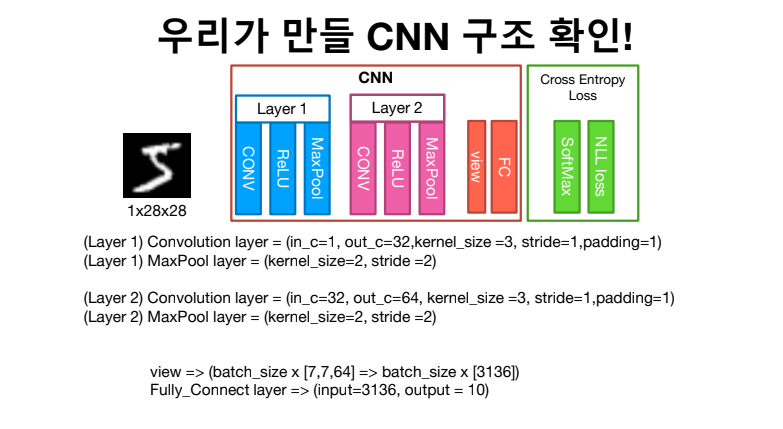

## **1. 라이브러리 가져오기**

In [2]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

## **2. GPU 사용 설정, Random value를 위한 seed 설정**

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

## **3. Parameter 설정**

In [4]:
learning_rate = 0.001
batch_size = 100
training_epochs = 15

## **4. Dataset 가져오기, loader 만들기**

In [14]:
mnist_train = dsets.MNIST(root = './',
                          train = True,
                          transform = transforms.ToTensor(),
                          download = True)
mnist_test = dsets.MNIST(root = './',
                          train = False,
                          transform = transforms.ToTensor(),
                          download = True)

data_loader = torch.utils.data.DataLoader(dataset = mnist_train,
                                          batch_size = batch_size,
                                          shuffle = True,
                                          drop_last = True)

## **5. 학습 모델 만들기**

In [12]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # CNN 클래스의 부모 클래스인 torch.nn.Module 클래스의 생성자를 호출하여 초기화를 수행
        # L1 ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2) #(2, 2)
        )
        # L2 ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding =1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Final FC 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias = True)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # batch수만 고려하고 나머지는 flatten
        out = self.fc(out)
        return out

model = CNN().to(device)

## **6. Loss Function, Optimizer 선택**

In [8]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

## **7. 모델 학습 및 loss check**

In [15]:
total_batch = len(data_loader)
print('Learning started. It takes sometime.')

for epoch in range(1, training_epochs+1):
    avg_cost = 0

    for X, Y in data_loader:
        X = X.to(device)
        Y = Y.to(device)

        hypothesis = model(X)
        cost = criterion(hypothesis, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        avg_cost += cost/total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch, avg_cost))

print('Learning Finished!')

Learning started. It takes sometime.
[Epoch:    1] cost = 2.33059955
[Epoch:    2] cost = 2.33059835
[Epoch:    3] cost = 2.3305974
[Epoch:    4] cost = 2.33059931
[Epoch:    5] cost = 2.33059645
[Epoch:    6] cost = 2.33059764
[Epoch:    7] cost = 2.33059716
[Epoch:    8] cost = 2.33059883
[Epoch:    9] cost = 2.3305974
[Epoch:   10] cost = 2.3305974
[Epoch:   11] cost = 2.3305974
[Epoch:   12] cost = 2.33059692
[Epoch:   13] cost = 2.33059859
[Epoch:   14] cost = 2.33059669
[Epoch:   15] cost = 2.33059716
Learning Finished!


## **8. 학습된 모델 성능 확인**

In [22]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.07440000027418137


Label:  5
Prediction:  2


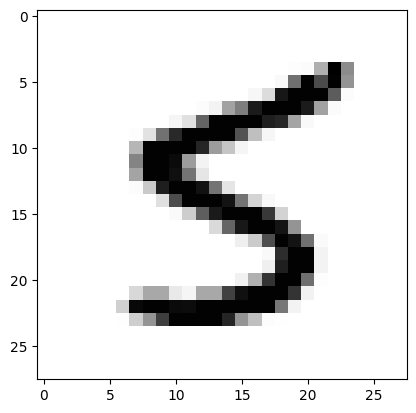

In [35]:
    #Get one and predict
    import matplotlib.pyplot as plt
    import random
    r = random.randint(0, len(mnist_test)-1)
    X_single_data = mnist_test.test_data[r:r+1].view(1, 1, 28, 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r+1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r+1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()